# Установка зависимостей, настройка окржения и импорт библиотек:

In [ ]:
!pip install faiss-cpu gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine =

In [ ]:
import json
from google.colab import userdata

kaggle_config = json.loads(
    userdata.get('KAGGLE_CONFIG')
)

with open("kaggle.json", "w") as file:
    json.dump(kaggle_config, file)

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

import faiss
import pickle
import json
import os
import gradio as gr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from typing import List, Tuple, Union, Optional

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Загрузка и обработка данных:

In [ ]:
DATASET_URL = "gulsahdemiryurek/harry-potter-dataset"

api = KaggleApi()
api.authenticate()
api.dataset_download_files(DATASET_URL)
!unzip harry-potter-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/gulsahdemiryurek/harry-potter-dataset
Archive:  harry-potter-dataset.zip
  inflating: Characters.csv          
  inflating: Harry Potter 1.csv      
  inflating: Harry Potter 2.csv      
  inflating: Harry Potter 3.csv      
  inflating: Potions.csv             
  inflating: Spells.csv              
  inflating: shortversioncharacters.csv  


In [ ]:
parts = []

process = lambda text: text.strip().lower()

for i in range(3):

    part = pd.read_csv(f"Harry Potter {i+1}.csv", sep=';')
    part.columns = [*map(str.lower, part.columns)]

    part.iloc[:, 0] = part.iloc[:, 0].apply(process)
    part.iloc[:, 1] = part.iloc[:, 1].apply(process)

    parts.append(part)

all_parts_df = pd.concat(parts, axis=0)
all_parts_df.head()

,character,sentence
0,dumbledore,"i should've known that you would be here, prof..."
1,mcgonagall,"good evening, professor dumbledore."
2,mcgonagall,"are the rumors true, albus?"
3,dumbledore,"i'm afraid so, professor."
4,dumbledore,the good and the bad.


# EDA:

In [ ]:
count_sents = all_parts_df.character.value_counts()
count_sents.nlargest(20)

,count
character,
harry,1028
ron,536
hermione,485
hagrid,394
dumbledore,239
lupin,207
mcgonagall,152
snape,121
gilderoy lockhart,113


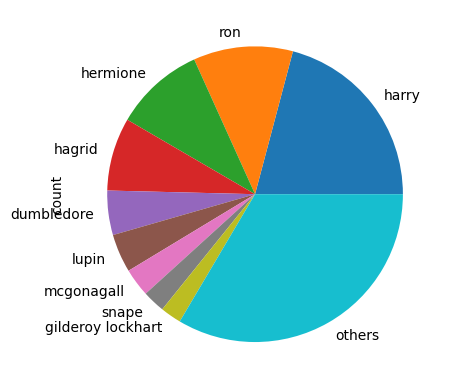

In [ ]:
count_sents["others"] = count_sents[count_sents < 100].sum()
count_sents = count_sents[count_sents >= 100]
count_sents.plot.pie();

In [ ]:
harry_replicas = all_parts_df[all_parts_df.character == "harry"].sentence
harry_replicas.sample(10)

,sentence
1348,because no one did look it in the eye.
1494,"what do you mean, she won't wake?"
587,it's mrs. norris.
13,yes.
166,"dear mr. potter,"
1058,professor trelawney...
612,listen.
1495,she's not...?
1311,"besides, dead, the truth dies with him."
84,i fell over.


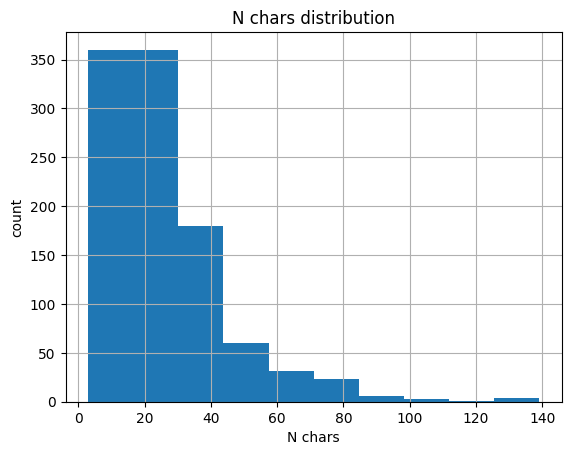

In [ ]:
harry_replicas.apply(len).hist()

plt.title("N chars distribution")
plt.xlabel("N chars")
plt.ylabel("count")
plt.show()

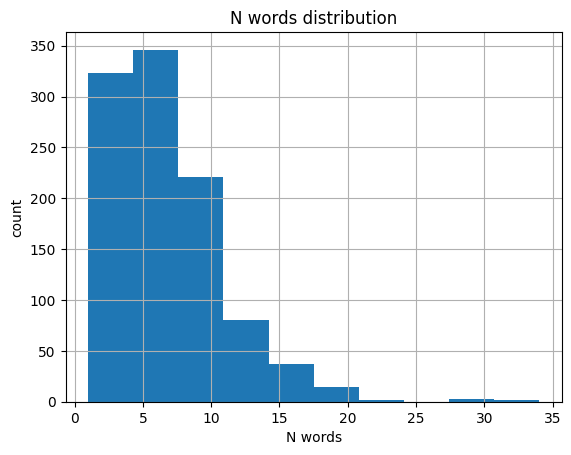

In [ ]:
harry_replicas.apply(lambda x: len(word_tokenize(x))).hist()

plt.title("N words distribution")
plt.xlabel("N words")
plt.ylabel("count")
plt.show()

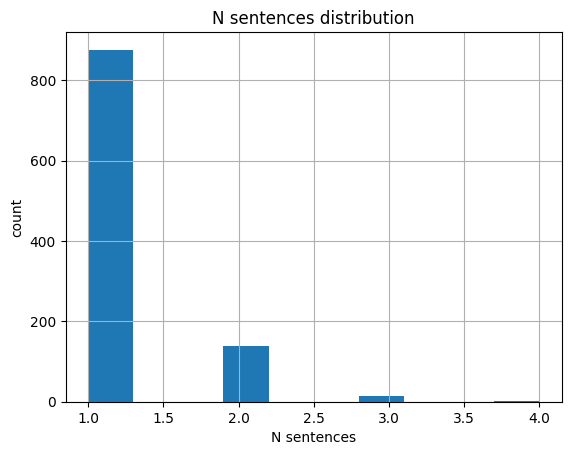

In [ ]:
harry_replicas.apply(lambda x: len(sent_tokenize(x))).hist()

plt.title("N sentences distribution")
plt.xlabel("N sentences")
plt.ylabel("count")
plt.show()

# Составление корпуса реплик

In [ ]:
harry_corpus = []

for replic in harry_replicas:
    harry_corpus += sent_tokenize(replic)

harry_corpus = [*set(harry_corpus)]

len(harry_replicas), len(harry_corpus)

(1028, 1035)

# Код ретривера

In [ ]:
class Retriever:

    def __init__(self, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2',
                 faiss_params: dict = {'metric_type': faiss.METRIC_INNER_PRODUCT, 'hnsw_ef': 128}):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        self.faiss_params = faiss_params
        self.index = None
        self.corpus = []
        self._normalize = (faiss_params.get('metric_type', 0) == faiss.METRIC_INNER_PRODUCT)

    def load_corpus(self, texts: List[str]) -> None:
        """Загрузка и индексация корпуса текстов"""
        self.corpus = texts
        embeddings = self.model.encode(texts, convert_to_numpy=True, normalize_embeddings=self._normalize)

        dim = embeddings.shape[1]
        self.index = faiss.IndexHNSWFlat(dim, 32, self.faiss_params['metric_type'])
        self.index.hnsw.efSearch = self.faiss_params.get('hnsw_ef', 128)

        if self._normalize:
            embeddings = embeddings.astype('float32')
        self.index.add(embeddings)

    def save_to_disk(self, path: str) -> None:
        """Сохранение модели, индекса и корпуса на диск"""
        os.makedirs(path, exist_ok=True)

        # Сохраняем корпус
        with open(os.path.join(path, 'corpus.pkl'), 'wb') as f:
            pickle.dump(self.corpus, f)

        # Сохраняем индекс
        faiss.write_index(self.index, os.path.join(path, 'index.faiss'))

        # Сохраняем конфигурацию
        config = {
            'model_name': self.model_name,
            'faiss_params': self.faiss_params
        }
        with open(os.path.join(path, 'config.json'), 'w') as f:
            json.dump(config, f)

    @classmethod
    def load_from_disk(cls, path: str) -> 'Retriever':
        """Загрузка модели, индекса и корпуса с диска"""
        # Загрузка конфигурации
        with open(os.path.join(path, 'config.json'), 'r') as f:
            config = json.load(f)

        # Инициализация объекта
        retriever = cls(
            model_name=config['model_name'],
            faiss_params=config['faiss_params']
        )

        # Загрузка корпуса
        with open(os.path.join(path, 'corpus.pkl'), 'rb') as f:
            retriever.corpus = pickle.load(f)

        # Загрузка индекса
        retriever.index = faiss.read_index(os.path.join(path, 'index.faiss'))

        return retriever

    def encode_query(self, query: str) -> np.ndarray:
        """Векторизация текстового запроса"""
        embedding = self.model.encode([query], convert_to_numpy=True, normalize_embeddings=self._normalize)
        return embedding.astype('float32')

    def search(self, query: str, n: int = 5, return_scores: bool = False) -> Union[List[str], Tuple[List[str], List[float]]]:
        if not self.index:
            raise ValueError("Корпус не загружен. Сначала вызовите load_corpus()")

        query_embedding = self.encode_query(query)
        k_multiplier = 5
        _, candidates = self.index.search(query_embedding, k=n*k_multiplier)

        corpus_embeddings = self.model.encode([self.corpus[i] for i in candidates[0]],
                                           convert_to_numpy=True,
                                           normalize_embeddings=self._normalize)

        query_embedding = query_embedding / np.linalg.norm(query_embedding)
        corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
        scores = np.dot(corpus_embeddings, query_embedding.T).flatten()

        top_indices = np.argsort(-scores)[:n]
        final_results = [self.corpus[candidates[0][i]] for i in top_indices]

        if return_scores:
            percentages = ((scores[top_indices] + 1) / 2 * 100).round(2).tolist()
            return final_results, percentages

        return final_results

    def get_answer(self, query: str) -> str:
        results = self.search(query, n=1)
        return results[0]

    def create_chat_ui(self, title: str = "Виртуальный Гарри Поттер [EN]",
                      examples: Optional[List[str]] = None) -> gr.Blocks:
        """Создание Gradio интерфейса для чата"""
        def chat_fn(message: str, history: list):
            return self.get_answer(message)

        examples = examples or ["Hi!", "What is your name?"]

        return gr.ChatInterface(
            fn=chat_fn,
            title=title,
            examples=examples,
            chatbot=gr.Chatbot(height=400),
            textbox=gr.Textbox(placeholder="Введите ваш вопрос...", container=False, scale=7),
            description="Chat"
        )

# Обучение ретривера и демонстрация результатов:

In [ ]:
retriever = Retriever()
retriever.load_corpus(harry_corpus)
retriever.save_to_disk("saved_retriever")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
for result, score in zip(*retriever.search(
    "How are you?",
    return_scores=True
)):
    print(f"Score: {round(score, 2)}%\tSentence: '{result}'")

Score: 79.75%	Sentence: 'who are you?'
Score: 79.11%	Sentence: 'what are you doing?'
Score: 77.77%	Sentence: 'are you okay?'
Score: 76.3%	Sentence: 'where are you?'
Score: 73.91%	Sentence: 'you okay?'


# Проблема:
### C точки зрения диалогового бота, если искать реплики целевого персонажа наиболее близкие, к репликам пользователя, диалог не получается согласованным

# Решение:
### Искать в ретривере не реплики целевого персонажа, а те реплики, на которые он отвечает, а пользователю отправлять реплику-ответ целевого персонажа

In [ ]:
class Retriever2:

    def __init__(self, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2',
                 faiss_params: dict = {'metric_type': faiss.METRIC_INNER_PRODUCT, 'hnsw_ef': 128}):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        self.faiss_params = faiss_params
        self.index = None
        self.contexts: List[str] = []  # Реплики-стимулы
        self.responses: List[str] = []  # Ответы Гарри
        self._normalize = (faiss_params.get('metric_type', 0) == faiss.METRIC_INNER_PRODUCT)


    def load_corpus(self, texts: List[str]) -> None:
        """Загрузка и индексация корпуса текстов"""
        self.corpus = texts
        embeddings = self.model.encode(texts, convert_to_numpy=True, normalize_embeddings=self._normalize)

        dim = embeddings.shape[1]
        self.index = faiss.IndexHNSWFlat(dim, 32, self.faiss_params['metric_type'])
        self.index.hnsw.efSearch = self.faiss_params.get('hnsw_ef', 128)

        if self._normalize:
            embeddings = embeddings.astype('float32')
        self.index.add(embeddings)


    def load_dialogue_data(self, df: pd.DataFrame) -> None:
        """Формирует пары контекст-ответ из DataFrame"""
        self.contexts.clear()
        self.responses.clear()

        for i in range(1, len(df)):
            prev_row = df.iloc[i-1]
            curr_row = df.iloc[i]

            if curr_row['character'] == 'harry' and prev_row['character'] != 'harry':
                self.contexts.append(prev_row['sentence'])
                self.responses.append(curr_row['sentence'])

        self.load_corpus(self.contexts)


    def save_to_disk(self, path: str) -> None:
        """Сохранение модели, индекса и корпуса на диск"""
        os.makedirs(path, exist_ok=True)

        # Сохранение корпуса
        with open(os.path.join(path, 'responses.pkl'), 'wb') as f:
                pickle.dump(self.responses, f)

        # Сохранение индекса
        faiss.write_index(self.index, os.path.join(path, 'index.faiss'))

        # Сохранение конфигурации
        config = {
            'model_name': self.model_name,
            'faiss_params': self.faiss_params
        }
        with open(os.path.join(path, 'config.json'), 'w') as f:
            json.dump(config, f)

    @classmethod
    def load_from_disk(cls, path: str) -> 'Retriever':
        """Загрузка модели, индекса и корпуса с диска"""

        # Загрузка конфигурации
        with open(os.path.join(path, 'config.json'), 'r') as f:
            config = json.load(f)

        # Инициализация объекта
        retriever = cls(
            model_name=config['model_name'],
            faiss_params=config['faiss_params']
        )

        # Загрузка корпуса
        with open(os.path.join(path, 'responses.pkl'), 'rb') as f:
            retriever.responses = pickle.load(f)

        # Загрузка индекса
        retriever.index = faiss.read_index(os.path.join(path, 'index.faiss'))

        return retriever

    def encode_query(self, query: str) -> np.ndarray:
        """Векторизация текстового запроса"""
        embedding = self.model.encode([query], convert_to_numpy=True, normalize_embeddings=self._normalize)
        return embedding.astype('float32')

    def search(self, query: str, n: int = 5, return_scores: bool = False) -> Union[List[str], Tuple[List[str], List[float]]]:
        if not self.index:
            raise ValueError("Корпус не загружен. Сначала вызовите load_corpus()")

        query_embedding = self.encode_query(query)
        k_multiplier = 5
        _, candidates = self.index.search(query_embedding, k=n*k_multiplier)

        corpus_embeddings = self.model.encode([self.corpus[i] for i in candidates[0]],
                                           convert_to_numpy=True,
                                           normalize_embeddings=self._normalize)

        query_embedding = query_embedding / np.linalg.norm(query_embedding)
        corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
        scores = np.dot(corpus_embeddings, query_embedding.T).flatten()

        top_indices = np.argsort(-scores)[:n]
        final_results = [self.responses[candidates[0][i]] for i in top_indices]

        if return_scores:
            percentages = ((scores[top_indices] + 1) / 2 * 100).round(2).tolist()
            return final_results, percentages

        return final_results

    def get_answer(self, query: str) -> str:
        results = self.search(query, n=1)
        return results[0]

    def create_chat_ui(self, title: str = "Виртуальный Гарри Поттер [EN]",
                      examples: Optional[List[str]] = None) -> gr.Blocks:
        """Создание Gradio интерфейса для чата"""
        def chat_fn(message: str, history: list):
            return self.get_answer(message)

        examples = examples or ["Hi!", "What is your name?"]

        return gr.ChatInterface(
            fn=chat_fn,
            title=title,
            examples=examples,
            chatbot=gr.Chatbot(height=400),
            textbox=gr.Textbox(placeholder="Type something...", container=False, scale=7),
            description="Chat"
        )

In [ ]:
# Инициализация и сохранение
retriever = Retriever2()

retriever.load_dialogue_data(all_parts_df)
retriever.save_to_disk("saved_retriever2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Запуск интерфейса
retriever.create_chat_ui().launch()

/usr/local/lib/python3.11/dist-packages/gradio/components/chatbot.py:285: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:317: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ea7b6004408d2c414a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Скрин чата:

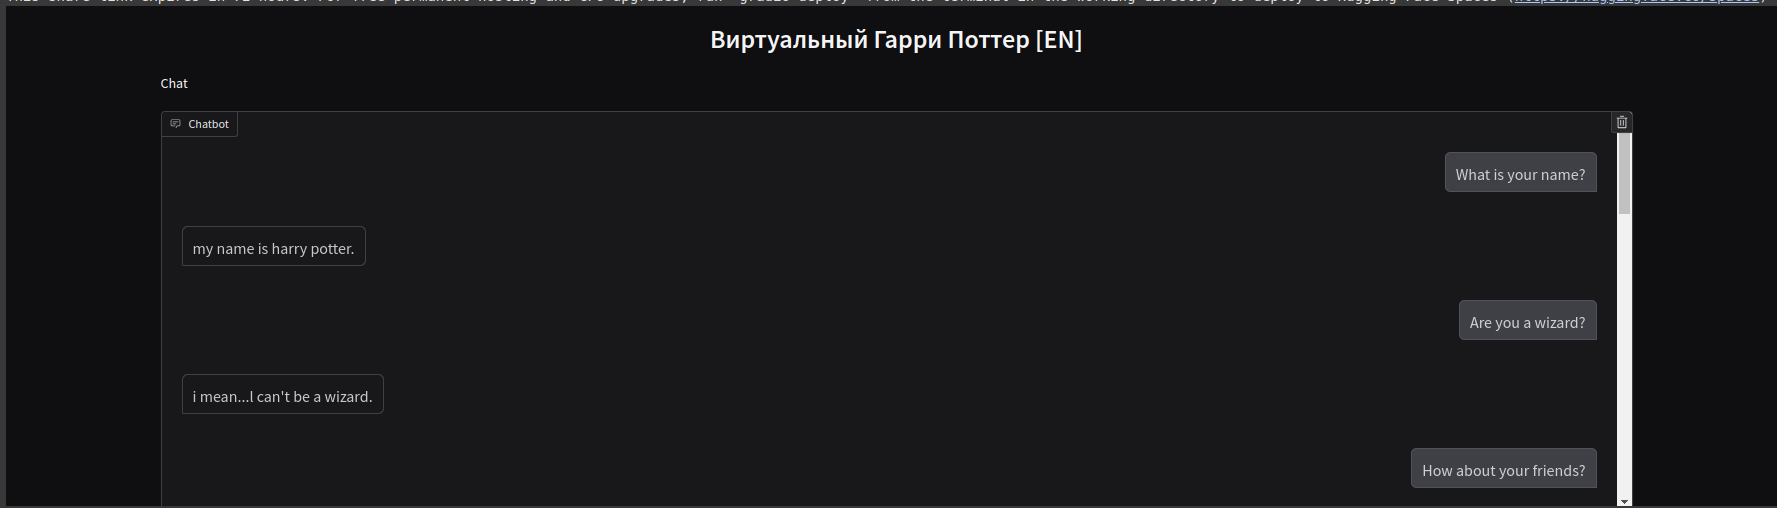

# Реализация RAG

In [ ]:
!pip install langchain_openai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.37
    Uninstalling langchain-core-0.3.37:
      Successfully uninstalled langchain-core-0.3.37


In [ ]:
from langchain import LLMChain, PromptTemplate
from langchain.llms import HuggingFaceHub
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
from typing import Optional, Dict, Any
import faiss

In [ ]:
SYS_PROMPT = """**Role:**
You are Harry Potter, a brave and witty wizard. Respond as the character, maintaining his style and tone.

**Instruction:**
Answer the question based on the provided context, using your magical knowledge and experiences. If you don't know the answer, say so. Keep your response concise and engaging.

**Example 1:**
Q: What is the best way to cast a successful Expelliarmus spell?
A: To cast Expelliarmus effectively, focus on your wand movement and incantation. Practice makes perfect!

**Example 2:**
Q: How do you handle a difficult situation with a friend?
A: I try to listen carefully and offer support. Sometimes, a friendly duel can help clear the air!

**Example 3:**
Q: What advice would you give to a first-year student at Hogwarts?
A: Be brave, make good friends, and always keep your wits about you. Don't be afraid to ask for help!
"""

In [ ]:
class RAG(Retriever2):

    def __init__(self,
                 model_name: str = 'sentence-transformers/all-MiniLM-L6-v2',
                 llm_model: str = 'HuggingFaceTB/SmolLM2-360M-Instruct',
                 system_prompt: str = SYS_PROMPT,
                 gen_params: Dict[str, Any] = None,
                 **kwargs):

        super().__init__(model_name, **kwargs)
        self.llm_model = llm_model
        self.system_prompt = system_prompt
        self.gen_params = gen_params or {
            'temperature': 0.7,
            'top_k': 40,
            'top_p': 0.9,
            'max_tokens': 500
        }

        self.tokenizer = AutoTokenizer.from_pretrained(llm_model)
        self.model = AutoModelForCausalLM.from_pretrained(llm_model)

        # Сохранение модели для кодирования
        self.encoder_model = SentenceTransformer(model_name)

        # Настройка LLM из Hugging Face
        self.llm = HuggingFaceHub(repo_id=llm_model)

    def load_dialogue_data(self, df: pd.DataFrame) -> None:
        """Формирует пары контекст-ответ из DataFrame"""
        self.contexts.clear()
        self.responses.clear()

        for i in range(1, len(df)):
            prev_row = df.iloc[i-1]
            curr_row = df.iloc[i]

            if curr_row['character'] == 'harry' and prev_row['character'] != 'harry':
                self.contexts.append(prev_row['sentence'])
                self.responses.append(curr_row['sentence'])

        # Загрузка контекстов в ретривер с использованием SentenceTransformer
        embeddings = self.encoder_model.encode(self.contexts, convert_to_numpy=True)

        dim = embeddings.shape[1]
        self.index = faiss.IndexHNSWFlat(dim, 32, faiss.METRIC_INNER_PRODUCT)
        self.index.hnsw.efSearch = 128

        self.index.add(embeddings)

    def encode_query(self, query: str) -> np.ndarray:
        """Векторизация текстового запроса"""
        embedding = self.encoder_model.encode([query], convert_to_numpy=True)
        return embedding.astype('float32')

    def search(self, query: str, n: int = 5, return_scores: bool = False) -> Union[List[str], Tuple[List[str], List[float]]]:
        if not self.index:
            raise ValueError("Корпус не загружен. Вызовите load_corpus()")

        query_embedding = self.encode_query(query)
        k_multiplier = 5
        _, candidates = self.index.search(query_embedding, k=n*k_multiplier)

        # encoder_model для эмбеддингов ретривера
        corpus_embeddings = self.encoder_model.encode([self.contexts[i] for i in candidates[0]], convert_to_numpy=True)

        query_embedding = query_embedding / np.linalg.norm(query_embedding)
        corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
        scores = np.dot(corpus_embeddings, query_embedding.T).flatten()

        top_indices = np.argsort(-scores)[:n]
        final_results = [self.contexts[candidates[0][i]] for i in top_indices]

        if return_scores:
            percentages = ((scores[top_indices] + 1) / 2 * 100).round(2).tolist()
            return final_results, percentages

        return final_results

    def generate_answer(self, query: str, k: int = 3) -> str:

        # Поиск релевантных ответов
        context_docs, scores = self.search(query, n=k, return_scores=True)

        # Формирование контекста
        context = "\n".join([f"[{i+1}] {doc}" for i, doc in enumerate(context_docs)])

        # Создание промпта для генерации
        prompt_template = PromptTemplate(
            input_variables=["context", "query"],
            template=f"{self.system_prompt}\n\n**Context (usual harry responds):**\n{context}\n\n**Question:**\n{query}\n\n**Answer:**\n"
        )

        # Создание цепочки генерации
        chain = prompt_template | self.llm

        # Генерация финального ответа
        response = chain.invoke({"context": context, "query": query})

        # Извлечение ответа из результата
        answer = response.split("**Answer:**\n")[1].strip()

        # Если ответ пустой, сообщение об отсутствии ответа
        if not answer:
            return "I don't know..."

        return answer


    def create_chat_ui(self, title: str = "Виртуальный Гарри Поттер [EN]",
                      examples: Optional[List[str]] = None) -> gr.Blocks:
        """Создание Gradio интерфейса для чата"""
        def chat_fn(message: str, history: list):
            return self.generate_answer(message, k=5)

        examples = examples or ["Hi!", "What is your name?"]

        return gr.ChatInterface(
            fn=chat_fn,
            title=title,
            examples=examples,
            chatbot=gr.Chatbot(height=400),
            textbox=gr.Textbox(placeholder="Введите ваш вопрос...", container=False, scale=7),
            description="Chat"
        )

In [ ]:
import os

HF_TOKEN = userdata.get('HF_TOKEN')
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN

In [ ]:
rag = RAG()
rag.load_dialogue_data(all_parts_df)

In [ ]:
response = rag.generate_answer("What can you recomend to take to Hogwarts?", k=5)
response

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


"Don't forget your wand, robes, and a good book for the Hogwarts Library. Oh, and a Nimbus 2000 wouldn't go amiss!"

In [ ]:
rag.create_chat_ui().launch()

/usr/local/lib/python3.11/dist-packages/gradio/components/chatbot.py:285: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:317: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a104118212f6bbbadd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
